In [1]:
import app
from lib.factor_analysis import plot_correlogram, plot_returns_corr, test_ljung_box, adf_test, find_volitile_month, \
run_regression, regress_all_macro_factors,identify_factor_contribution, restore_rets, stress_calc


# Prepare all the returns and factors

2024-11-07 13:55:44.010 | INFO     | app:preprocess_data:15 - Starting to preprocess data
2024-11-07 13:55:44.011 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TNX
2024-11-07 13:55:44.013 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SQ
2024-11-07 13:55:44.015 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^VIX
2024-11-07 13:55:44.017 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^XAU
2024-11-07 13:55:44.018 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^IRX
2024-11-07 13:55:44.020 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - RIOT
2024-11-07 13:55:44.022 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TYX
2024-11-07 13:55:44.025 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - NVDA
2024-11-07 13:55:44.026 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^FVX
2024-11-07 13:55:44.028 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SPY
2024-11-07 13:55:44.030


Explained Variance Ratio:
[0.3320984  0.15664933 0.10829306 0.07051034 0.0546004  0.04177548
 0.03312263 0.0302329  0.02808646 0.02406115]
Total Explained Variance Ratio: 0.8794


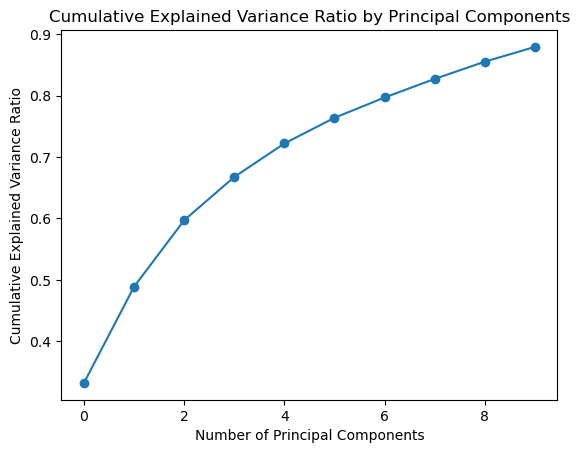

PCA Projection Loss 2.773106416033492


In [2]:
df1 , df_hist_ret, df_vol =app.preprocess_data()
s_crypto_market, s_big_market = app.construct_market_factors(df1)
df_rets0, pc_df0, df_factor_loadings0 = app.construct_pca_factors(df1, s_big_market, s_crypto_market, n=10, standardize_return=True)

<Axes: >

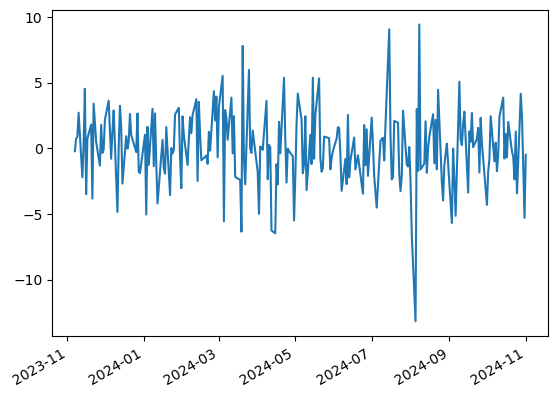

In [28]:
pc_df['PC1'].plot()

<Axes: >

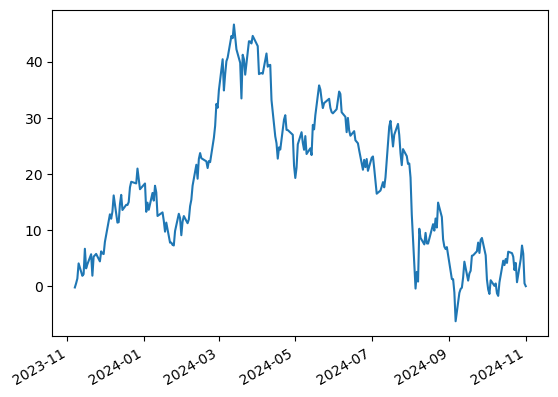

In [29]:
pc_df['PC1'].cumsum().plot()

<Axes: >

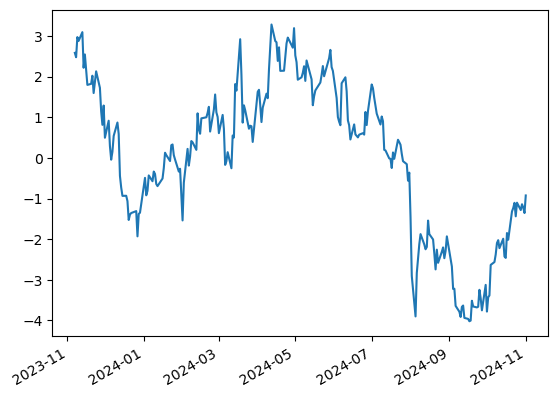

In [30]:
pc_df['PC2'].plot()

<Axes: >

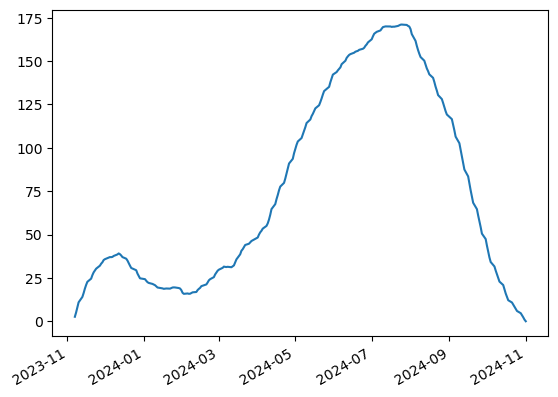

In [31]:
pc_df['PC2'].cumsum().plot()

<Axes: >

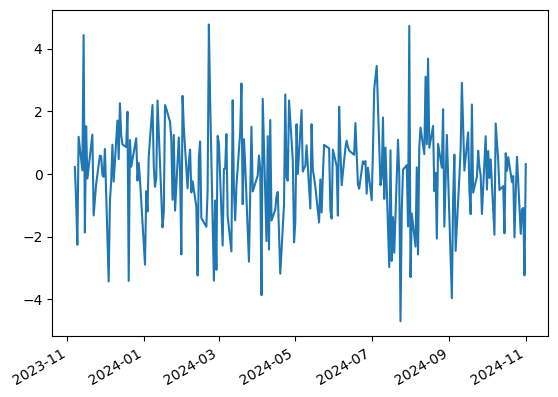

In [32]:
pc_df['PC3'].plot()

<Axes: >

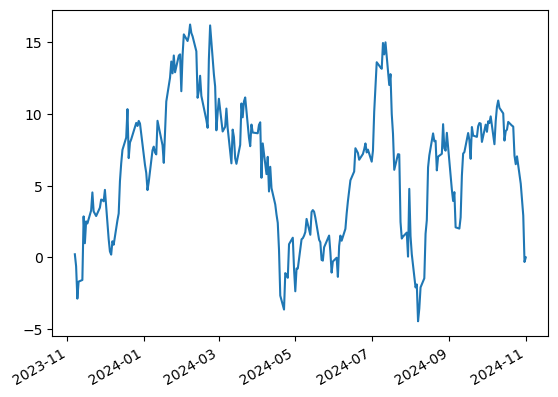

In [33]:
pc_df['PC3'].cumsum().plot()

# Use only 3 PCA factors to explain price moment of Bitcoin
- 3 factors explained 92.1% of the total variance of Bitcoin returns
- The 1st PCA explained 83.1%
- The 3rd PCA explained 8.9%

#### PC Scores of first 3 PCA components

In [3]:
n = 3
ticker = 'bitcoin_prices' # spy
scores =pc_df0.copy().iloc[:,:n]
scores.index=df_rets0.index
scores

,PC1,PC2,PC3
2023-11-07,-0.229360,2.586155,0.221367
2023-11-08,0.735409,2.478731,-0.833084
2023-11-09,0.853809,2.975260,-2.261657
2023-11-10,2.701017,2.880897,1.186746
2023-11-13,-2.215225,3.096667,0.115660
...,...,...,...
2024-10-28,4.138178,-1.284060,-1.915031
2024-10-29,2.392443,-1.141308,-1.127691
2024-10-30,-1.447593,-1.220850,-1.085543
2024-10-31,-5.294057,-1.357342,-3.238302


#### First three factor loadings

In [4]:
import pandas as pd
loadings = df_factor_loadings0[ticker][:n]
loadings=pd.DataFrame(loadings)
loadings.index=scores.columns
loadings

,bitcoin_prices
PC1,0.329768
PC2,-0.012105
PC3,-0.189513


In [5]:
pc_df=pc_df0.copy()
df_rets=df_rets0.copy()

In [6]:
# prepare dataframe
pc_df.index=df_rets0.index
df_rets=df_rets0.join(pc_df)

### Restored Bitcoin Returns from 3 PC scores

<Axes: >

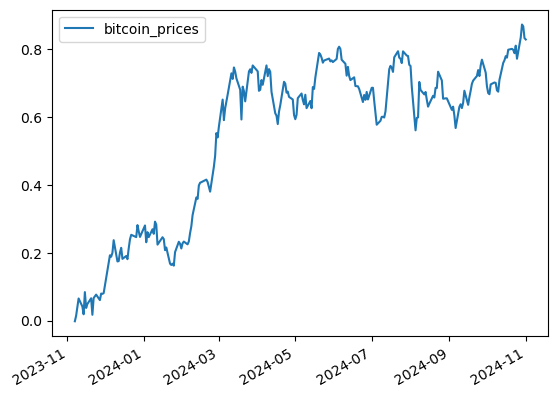

In [7]:
proj= scores.dot(loadings) #
restored = proj*df_rets[ticker].std() + df_rets[ticker].mean()
restored.cumsum().plot()

### Compare with original return

<Axes: >

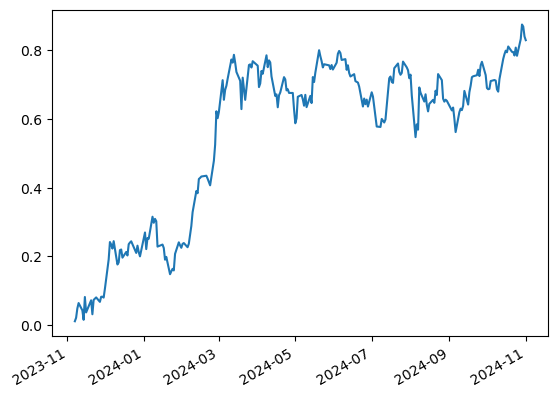

In [8]:
df_rets[ticker].cumsum().plot()

In [9]:
restored[f'original_{ticker}_ret'] = df_rets[ticker]
restored

,bitcoin_prices,original_bitcoin_prices_ret
2023-11-07,-0.001752,0.011569
2023-11-08,0.015971,0.010118
2023-11-09,0.026339,0.027192
2023-11-10,0.024864,0.015661
2023-11-13,-0.023631,-0.021291
...,...,...
2024-10-28,0.062824,0.048954
2024-10-29,0.038023,0.042033
2024-10-30,-0.005437,-0.006025
2024-10-31,-0.034749,-0.028719


# Factor Contribution for Bitcoin 

In [10]:
m_3=run_regression(df_rets, ["PC1","PC2","PC3"], 'bitcoin_prices',plot_chart=False)
print(f"3 PCA model expalined {m_3.rsquared:.1%} of variance")

3 PCA model expalined 92.1% of variance


In [11]:
m=run_regression(df_rets, ["PC1","PC2"], 'bitcoin_prices',plot_chart=False)
pc3_contribution = m_3.rsquared - m.rsquared
print(f"PC3 expalined {pc3_contribution:.1%} of variance")

PC3 expalined 8.9% of variance


#### Factor Contribution for all cryptos

In [12]:

factor_contributions = identify_factor_contribution(df_rets)        
    
with pd.option_context("display.float_format", "{:.1%}".format):
    display(factor_contributions.T)


,R2_3 PCs,PC1,PC2,PC3
bitcoin_prices,92.1%,83.1%,0.1%,8.9%
usd-coin_prices,1.0%,1.0%,0.1%,0.0%
tether_prices,5.6%,4.4%,0.0%,1.1%
solana_prices,57.6%,54.9%,0.0%,2.8%
chainlink_prices,66.2%,64.7%,0.2%,1.3%
ripple_prices,48.4%,43.4%,0.3%,4.8%
ethereum_prices,75.9%,71.3%,0.0%,4.6%
binancecoin_prices,52.9%,49.3%,0.4%,3.2%
dogecoin_prices,65.6%,59.6%,0.2%,5.9%


# Stress Testing

In [87]:
# this is copied over from GARCH, Volatility Clustering and Correlations.ipynb
high_vol_dates=['2024-03-12', '2024-03-21', '2024-03-22', '2024-03-26',
               '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-09',
               '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
               '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19',
               '2024-04-23', '2024-08-07', '2024-08-09', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22',
               '2024-08-23', '2024-08-26', '2024-08-27', '2024-08-28',
               '2024-08-29', '2024-08-30', '2024-09-03', '2024-09-04',
               '2024-09-05']

In [88]:
pc_score_high_vol_period = pc_df[pc_df.index.isin(high_vol_dates)].describe()

/var/folders/gz/yxd7yqrx3bx691j1zt5j255w0000gp/T/ipykernel_61943/1196698956.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  pc_score_high_vol_period = pc_df[pc_df.index.isin(high_vol_dates)].describe()


In [89]:
pc_score_high_vol_period

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.954314,-0.238373,0.072134,0.157042,0.115852,0.173742,0.199561,-0.100462,0.041221,0.053815
std,2.315273,2.176155,1.822000,1.416743,0.836464,0.933287,0.841505,0.560663,1.043271,0.543107
min,-6.476284,-3.226859,-3.967990,-4.282199,-1.854275,-2.322072,-1.020775,-2.242546,-1.479848,-0.992857
25%,-1.870986,-2.259539,-0.787786,-0.478526,-0.545980,-0.387478,-0.397537,-0.447954,-0.610742,-0.313530
50%,-0.427788,0.393387,0.197046,0.355376,0.314739,-0.039739,0.145902,-0.056175,-0.094474,-0.054104
75%,0.123378,1.626628,1.245630,1.084559,0.695411,0.813414,0.473681,0.312902,0.445734,0.413389
max,4.439392,3.284318,3.684300,2.862248,1.867334,2.011298,4.006688,1.013388,5.010271,1.470420


In [90]:
means= df_rets0.mean()    
stressed_PC1_score =  - 2*scores['PC1'].std()
stressed_PC2_score =  - 2*scores['PC2'].std()
stressed_PC3_score =  - 2*scores['PC3'].std()

result_pc_shock = {
    'PC1_shock':stress_calc({'PC1': stressed_PC1_score}, df_factor_loadings0,df_rets0),
     'PC2_shock':stress_calc({'PC2': stressed_PC1_score}, df_factor_loadings0,df_rets0),
    'PC3_shock':stress_calc({'PC3': stressed_PC1_score}, df_factor_loadings0,df_rets0),
      'combined': stress_calc({'PC1': stressed_PC1_score, "PC2": stressed_PC2_score, 'PC3': stressed_PC3_score}, df_factor_loadings0,df_rets0),
      }
result_pc_shock=pd.DataFrame(result_pc_shock)

result_pc_shock['hist_high_vol_shock'] = stress_calc({'PC1': pc_score_high_vol_period.loc['min','PC1'], }, df_factor_loadings0,df_rets0)
result_pc_shock

,PC1_shock,PC2_shock,PC3_shock,combined,hist_high_vol_shock
bitcoin_prices,-0.059009,0.005618,0.039155,-0.036980,-0.069563
usd-coin_prices,-0.000182,-0.000064,-0.000025,-0.000244,-0.000214
tether_prices,-0.000353,0.000001,-0.000312,-0.000526,-0.000413
solana_prices,-0.075248,0.005974,0.039309,-0.057542,-0.089178
chainlink_prices,-0.078569,0.007250,0.020298,-0.062789,-0.091977
ripple_prices,-0.050093,0.005062,0.028097,-0.029764,-0.058465
ethereum_prices,-0.067072,-0.000162,0.032664,-0.050986,-0.078757
binancecoin_prices,-0.048209,0.010407,0.027415,-0.030392,-0.057042
dogecoin_prices,-0.086066,0.012045,0.054457,-0.052482,-0.101415
SQ_Close,-0.021995,0.005690,-0.046196,-0.046862,-0.026041
